In [1]:
%matplotlib inline

In [2]:
import warnings
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from copy import deepcopy
from scipy import stats
from scipy.special import comb

import seaborn as sns
import matplotlib.pyplot as plt

import flowanalysis.definitions as fa

import csv
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

In [3]:
sns.set_style("ticks")
plt.rcParams.update({"text.usetex": True})
plt.rcParams["text.latex.preamble"] = r"\usepackage{graphicx}"
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [4]:
absolute_numbers = False
mean_only_venn = True

In [5]:
time_names = ("Primary", "Memory", "WT challenge", "T8A challenge", "N3A challenge")
naiveColumns = ("WT column", "T8A column", "N3A column")
tetramerNames = ("WT", "T8A", "N3A")
naive_stats_column_names = [
    "SP [WT]",
    "T8A [WT]",
    "N3A [WT]",
    "TP [WT]",
    "SP [T8A]",
    "WT [T8A]",
    "N3A [T8A]",
    "TP [T8A]",
    "SP [N3A]",
    "WT [N3A]",
    "T8A [N3A]",
    "TP [N3A]",
]

# Data formating

For each timepoint and sample the data needs to be formated as a 7-tuple, ordered as follows:
1. WT single positive cells
2. T8A single positive cells
3. WT + T8A double positive cells
4. N3A single positive cells
5. WT + N3A double positive cells
6. T8A + N3A double positive cells
7. WT + T8A + N3A triple positive cells

For each priming infection the data is stored on a list indexed as follows:
1. Mouse
2. Timepoint

If there are fewer mice on one of the timepoints the remaining entries on the list must be (-1, 0, 0, 0, 0, 0, 0) to make sure that the mean is correctly calculated

When reading the data the headers are put in a list ordred as follows:
1. Tissue
2. Timepoint
3. WT single positive cells
4. T8A single positive cells
5. WT + T8A double positive cells
6. N3A single positive cells
7. N3A + WT double positive cells
8. N3A + T8A double positive cells
9. WT + T8A + N3A triple positive cells
10. Total CD8 cells

# Spleen
## Circulating

In [6]:
fa.header_clipping("WT", check=True)
fa.header_clipping("T8A", check=True)
fa.header_clipping("N3A", check=True)

['Mouse', 'Cell_Count', 'Tissue', 'Condition', 'Sample:', 'Lymphocytes', 'Singlets', 'Live Cells', 'F480 B220 Negative', 'CD8p_Freq', 'CD8p_Norm_Freq', 'CD8p_Num', 'CD8p_N3ATotal_Freq', 'CD8p_N3ATotal_Num', 'CD8p_T8ATotal_Freq', 'CD8p_T8ATotal_Num', 'CD8p_WTTotal_Freq', 'CD8p_WTTotal_Num', 'CD8p_TriplePos_Freq', 'CD8p_TriplePos_Num', 'CD8p_N3AT8ADP_Freq', 'CD8p_N3AT8ADP_Num', 'CD8p_WTN3ADP_Freq', 'CD8p_WTN3ADP_Num', 'CD8p_WTT8ADP_Freq', 'CD8p_WTT8ADP_Num', 'WTSP_Freq', 'WTSP_Num', 'N3ASP_Freq', 'N3ASP_Num', 'T8ASP_Freq', 'T8ASP_Num']
['Mouse', 'Cell Count', 'Tissue', 'T8A Primary', 'Sample:', 'Lymphocytes', 'Singlets', 'Live Cells', 'F480 B220 Negative', 'CD8p_Freq', 'CD8p_Norm_Freq', 'CD8p_Num', 'CD8p_N3ATotal_Freq', 'CD8p_N3ATotal_Num', 'CD8p_T8ATotal_Freq', 'CD8p_T8ATotal_Num', 'CD8p_WTTotal_Freq', 'CD8p_WTTotal_Num', 'CD8p_TriplePos_Freq', 'CD8p_TriplePos_Num', 'CD8p_N3AT8ADP_Freq', 'CD8p_N3AT8ADP_Num', 'CD8p_WTN3ADP_Freq', 'CD8p_WTN3ADP_Num', 'CD8p_WTT8ADP_Freq', 'CD8p_WTT8ADP_Num

In [7]:
fa.header_clipping("WT")
fa.header_clipping("T8A")
fa.header_clipping("N3A")

wt_p_headers = [
    "Tissue",
    "Condition",
    "WTSP_Num",
    "T8ASP_Num",
    "N3ASP_Num",
    "CD8p_WTT8ADP_Num",
    "CD8p_WTN3ADP_Num",
    "CD8p_N3AT8ADP_Num",
    "CD8p_TriplePos_Num",
    "CD8p_Num",
]
t8a_p_headers = [
    "Tissue",
    "T8A Primary",
    "CD8p_WTSP_Num",
    "CD8p_T8ASP_Num",
    "CD8p_N3ASP_Num",
    "CD8p_WTT8ADP_Num",
    "CD8p_WTN3ADP_Num",
    "CD8p_N3AT8ADP_Num",
    "CD8p_TriplePos_Num",
    "CD8p_Num",
]
n3a_p_headers = [
    "Tissue",
    "Infection",
    "CD8p_WTSP_Num",
    "CD8p_T8ASP_Num",
    "CD8p_N3ASP_Num",
    "CD8p_WTT8ADP_Num",
    "CD8p_N3AWTDP_Num",
    "CD8p_N3AT8ADP_Num",
    "CD8p_TriplePos_Num",
    "CD8+CD45-_Norm_Num",
]

wt_p_time_names = fa.time_name_list("WT", wt_p_headers)
t8a_p_time_names = fa.time_name_list("T8A", t8a_p_headers)
n3a_p_time_names = fa.time_name_list("N3A", n3a_p_headers)

wt_spleen_circ_exp = fa.data_extraction(
    "WT",
    "spleen",
    wt_p_headers,
    wt_p_time_names,
    standard_names=time_names,
    timepoints=5,
)
t8a_spleen_circ_exp = fa.data_extraction(
    "T8A",
    "spleen",
    t8a_p_headers,
    t8a_p_time_names,
    standard_names=time_names,
    timepoints=5,
)
n3a_spleen_circ_exp = fa.data_extraction(
    "N3A",
    "spleen",
    n3a_p_headers,
    n3a_p_time_names,
    standard_names=time_names,
    timepoints=5,
)

### Venn plots

In [8]:
wt_spleen_circ_exp.venn_plot(
    "Fig-Venn/V-WT-S-Cir", frequency=False, mean_only=mean_only_venn
)
wt_spleen_circ_exp.venn_plot(
    "Fig-Venn/V-WT-S-Cir-F", frequency=True, labels=False, mean_only=mean_only_venn
)

In [9]:
t8a_spleen_circ_exp.venn_plot(
    "Fig-Venn/V-T8A-S-Cir", frequency=False, mean_only=mean_only_venn
)
t8a_spleen_circ_exp.venn_plot(
    "Fig-Venn/V-T8A-S-Cir-F", frequency=True, labels=False, mean_only=mean_only_venn
)

/Users/danny/anaconda3/envs/P37T2/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")


In [10]:
n3a_spleen_circ_exp.venn_plot(
    "Fig-Venn/V-N3A-S-Cir", frequency=False, mean_only=mean_only_venn
)
n3a_spleen_circ_exp.venn_plot(
    "Fig-Venn/V-N3A-S-Cir-F", frequency=True, labels=False, mean_only=mean_only_venn
)

/Users/danny/anaconda3/envs/P37T2/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


### Slopes

In [11]:
wt_spleen_circ_exp.slope_plot("Fig-Slopes/L-WT-S-Cir")

In [12]:
t8a_spleen_circ_exp.slope_plot("Fig-Slopes/L-T8A-S-Cir")

In [13]:
n3a_spleen_circ_exp.slope_plot("Fig-Slopes/L-N3A-S-Cir")

## Resident

In [14]:
fa.header_clipping("WT", cd45="-", check=True)
fa.header_clipping("T8A", cd45="-", check=True)
fa.header_clipping("N3A", cd45="-", check=True)

['Mouse', 'Cell Count', 'Tissue', 'Condition', 'Sample:', 'Lymphocytes', 'Singlets', 'Live Cells', 'F480 B220 Negative', 'CD8n_Freq', 'CD8n_Norm_Freq', 'CD8n_Num', 'CD8n_N3ATotal_Freq', 'CD8n_N3ATotal_Num', 'CD8n_T8ATotal_Freq', 'CD8n_T8Atotal_Num', 'CD8n_WTTotal_Freq', 'CD8n_WTTotal_Num', 'CD8n_Triplepos_Freq', 'CD8n_Triplepos_Num', 'CD8n_N3AT8ADP_Freq', 'CD8n_N3AT8ADP_Num', 'CD8n_WTN3ADP_Freq', 'CD8n_WTN3ADP_Num', 'CD8n_WTT8ADP_Freq', 'CD8n_WTT8ADP_Num', 'CD8n_WTSP_Freq', 'CD8n_WTSP_Num', 'CD8n_N3ASP_Freq', 'CD8n_N3ASP_Num', 'CD8n_T8ASP_Freq', 'CD8n_T8ASP_Num', 'Triple Neg', 'total frequency tet+ cells']
['Mouse', 'Cell Count', 'Tissue', 'Infection', 'Sample:', 'Lymphocytes', 'Singlets', 'Live Cells', 'F480 B220 Negative', 'CD8n_Freq', 'CD8n_Norm_Freq', 'CD8n_Num', 'CD8n_N3A_Total_Freq', 'CD8n_N3A_Total_Num', 'CD8n_T8ATotalFreq', 'CD8p_T8ATotal_Num', 'CD8p_WTTotal_Freq', 'CD8p_WTTotal_Num', 'CD8p_TriplePos_Freq', 'CD8p_TriplePos_Num', 'CD8p_N3AT8ADP_Freq', 'CD8p_N3AT8ADP_Num', 'CD8p_

In [15]:
fa.header_clipping("WT", cd45="-")
fa.header_clipping("T8A", cd45="-")
fa.header_clipping("N3A", cd45="-")

wt_n_headers = [
    "Tissue",
    "Condition",
    "CD8n_WTSP_Num",
    "CD8n_T8ASP_Num",
    "CD8n_N3ASP_Num",
    "CD8n_WTT8ADP_Num",
    "CD8n_WTN3ADP_Num",
    "CD8n_N3AT8ADP_Num",
    "CD8n_Triplepos_Num",
    "CD8n_Num",
]
t8a_n_headers = [
    "Tissue",
    "Infection",
    "CD8p_WTSP_Num",
    "CD8p_T8ASP_Num",
    "CD8p_N3ASP_Num",
    "CD8p_WTT8ADP_Num",
    "CD8p_WTN3ADP_Num",
    "CD8p_N3AT8ADP_Num",
    "CD8p_TriplePos_Num",
    "CD8n_Num",
]
n3a_n_headers = [
    "Tissue",
    "Infection",
    "CD8n_WTSP_Num",
    "CD8n_T8ASP_Num",
    "CD8n_N3ASP_Num",
    "CD8n_WTT8ADP_Num",
    "CD8n_N3AWTDP_Num",
    "CD8n_N3AT8ADP_Num",
    "CD8n_TriplePos_Num",
    "CD8+CD45-_Norm_Num",
]

wt_n_time_names = fa.time_name_list("WT", wt_n_headers, cd45="-")
t8a_n_time_names = fa.time_name_list("T8A", t8a_n_headers, cd45="-")
n3a_n_time_names = fa.time_name_list("N3A", n3a_n_headers, cd45="-")

wt_spleen_res_exp = fa.data_extraction(
    "WT",
    "spleen",
    wt_n_headers,
    wt_n_time_names,
    standard_names=time_names,
    cd45="-",
    timepoints=5,
)
t8a_spleen_res_exp = fa.data_extraction(
    "T8A",
    "spleen",
    t8a_n_headers,
    t8a_n_time_names,
    standard_names=time_names,
    cd45="-",
    timepoints=5,
)
n3a_spleen_res_exp = fa.data_extraction(
    "N3A",
    "spleen",
    n3a_n_headers,
    n3a_n_time_names,
    standard_names=time_names,
    cd45="-",
    timepoints=5,
)

### Venn plots

In [16]:
wt_spleen_res_exp.venn_plot(
    "Fig-Venn/V-WT-S-Res", frequency=False, mean_only=mean_only_venn
)
wt_spleen_res_exp.venn_plot(
    "Fig-Venn/V-WT-S-Res-F", frequency=True, labels=False, mean_only=mean_only_venn
)

In [17]:
t8a_spleen_res_exp.venn_plot(
    "Fig-Venn/V-T8A-S-Res", frequency=False, mean_only=mean_only_venn
)
t8a_spleen_res_exp.venn_plot(
    "Fig-Venn/V-T8A-S-Res-F", frequency=True, labels=False, mean_only=mean_only_venn
)

In [18]:
n3a_spleen_res_exp.venn_plot(
    "Fig-Venn/V-N3A-S-Res", frequency=False, mean_only=mean_only_venn
)
n3a_spleen_res_exp.venn_plot(
    "Fig-Venn/V-N3A-S-Res-F", frequency=True, labels=False, mean_only=mean_only_venn
)

### Slopes

In [19]:
wt_spleen_res_exp.slope_plot("Fig-Slopes/L-WT-S-Res")

In [20]:
t8a_spleen_res_exp.slope_plot("Fig-Slopes/L-T8A-S-Res")

In [21]:
n3a_spleen_res_exp.slope_plot("Fig-Slopes/L-N3A-S-Res")

# Lungs
## Circulating

In [22]:
fa.header_clipping("WT")
fa.header_clipping("T8A")
fa.header_clipping("N3A")

wt_p_headers = [
    "Tissue",
    "Condition",
    "WTSP_Num",
    "T8ASP_Num",
    "N3ASP_Num",
    "CD8p_WTT8ADP_Num",
    "CD8p_WTN3ADP_Num",
    "CD8p_N3AT8ADP_Num",
    "CD8p_TriplePos_Num",
    "CD8p_Num",
]
t8a_p_headers = [
    "Tissue",
    "T8A Primary",
    "CD8p_WTSP_Num",
    "CD8p_T8ASP_Num",
    "CD8p_N3ASP_Num",
    "CD8p_WTT8ADP_Num",
    "CD8p_WTN3ADP_Num",
    "CD8p_N3AT8ADP_Num",
    "CD8p_TriplePos_Num",
    "CD8p_Num",
]
n3a_p_headers = [
    "Tissue",
    "Infection",
    "CD8p_WTSP_Num",
    "CD8p_T8ASP_Num",
    "CD8p_N3ASP_Num",
    "CD8p_WTT8ADP_Num",
    "CD8p_N3AWTDP_Num",
    "CD8p_N3AT8ADP_Num",
    "CD8p_TriplePos_Num",
    "CD8+CD45-_Norm_Num",
]

wt_p_time_names = fa.time_name_list("WT", wt_p_headers)
t8a_p_time_names = fa.time_name_list("T8A", t8a_p_headers)
n3a_p_time_names = fa.time_name_list("N3A", n3a_p_headers)

wt_lungs_circ_exp = fa.data_extraction(
    "WT",
    "lungs",
    wt_p_headers,
    wt_p_time_names,
    standard_names=time_names,
    timepoints=5,
)
t8a_lungs_circ_exp = fa.data_extraction(
    "T8A",
    "lungs",
    t8a_p_headers,
    t8a_p_time_names,
    standard_names=time_names,
    timepoints=5,
)
n3a_lungs_circ_exp = fa.data_extraction(
    "N3A",
    "lungs",
    n3a_p_headers,
    n3a_p_time_names,
    standard_names=time_names,
    timepoints=5,
)

### Venn plots

In [23]:
wt_lungs_circ_exp.venn_plot(
    "Fig-Venn/V-WT-L-Cir", frequency=False, mean_only=mean_only_venn
)
wt_lungs_circ_exp.venn_plot(
    "Fig-Venn/V-WT-L-Cir-F", frequency=True, labels=False, mean_only=mean_only_venn
)

In [24]:
t8a_lungs_circ_exp.venn_plot(
    "Fig-Venn/V-T8A-L-Cir", frequency=False, mean_only=mean_only_venn
)
t8a_lungs_circ_exp.venn_plot(
    "Fig-Venn/V-T8A-L-Cir-F", frequency=True, labels=False, mean_only=mean_only_venn
)

In [25]:
n3a_lungs_circ_exp.venn_plot(
    "Fig-Venn/V-N3A-L-Cir", frequency=False, mean_only=mean_only_venn
)
n3a_lungs_circ_exp.venn_plot(
    "Fig-Venn/V-N3A-L-Cir-F", frequency=True, labels=False, mean_only=mean_only_venn
)

### Slopes

In [26]:
wt_lungs_circ_exp.slope_plot("Fig-Slopes/L-WT-L-Cir")

In [27]:
t8a_lungs_circ_exp.slope_plot("Fig-Slopes/L-T8A-L-Cir")

In [28]:
n3a_lungs_circ_exp.slope_plot("Fig-Slopes/L-N3A-L-Cir")

## Resident

In [29]:
fa.header_clipping("WT", cd45="-")
fa.header_clipping("T8A", cd45="-")
fa.header_clipping("N3A", cd45="-")

wt_n_headers = [
    "Tissue",
    "Condition",
    "CD8n_WTSP_Num",
    "CD8n_T8ASP_Num",
    "CD8n_N3ASP_Num",
    "CD8n_WTT8ADP_Num",
    "CD8n_WTN3ADP_Num",
    "CD8n_N3AT8ADP_Num",
    "CD8n_Triplepos_Num",
    "CD8n_Num",
]
t8a_n_headers = [
    "Tissue",
    "Infection",
    "CD8p_WTSP_Num",
    "CD8p_T8ASP_Num",
    "CD8p_N3ASP_Num",
    "CD8p_WTT8ADP_Num",
    "CD8p_WTN3ADP_Num",
    "CD8p_N3AT8ADP_Num",
    "CD8p_TriplePos_Num",
    "CD8n_Num",
]
n3a_n_headers = [
    "Tissue",
    "Infection",
    "CD8n_WTSP_Num",
    "CD8n_T8ASP_Num",
    "CD8n_N3ASP_Num",
    "CD8n_WTT8ADP_Num",
    "CD8n_N3AWTDP_Num",
    "CD8n_N3AT8ADP_Num",
    "CD8n_TriplePos_Num",
    "CD8+CD45-_Norm_Num",
]

wt_n_time_names = fa.time_name_list("WT", wt_n_headers, cd45="-")
t8a_n_time_names = fa.time_name_list("T8A", t8a_n_headers, cd45="-")
n3a_n_time_names = fa.time_name_list("N3A", n3a_n_headers, cd45="-")

wt_lungs_res_exp = fa.data_extraction(
    "WT",
    "lungs",
    wt_n_headers,
    wt_n_time_names,
    standard_names=time_names,
    cd45="-",
    timepoints=5,
)
t8a_lungs_res_exp = fa.data_extraction(
    "T8A",
    "lungs",
    t8a_n_headers,
    t8a_n_time_names,
    standard_names=time_names,
    cd45="-",
    timepoints=5,
)
n3a_lungs_res_exp = fa.data_extraction(
    "N3A",
    "lungs",
    n3a_n_headers,
    n3a_n_time_names,
    standard_names=time_names,
    cd45="-",
    timepoints=5,
)

### Venn plots

In [30]:
wt_lungs_res_exp.venn_plot(
    "Fig-Venn/V-WT-L-Res", frequency=False, mean_only=mean_only_venn
)
wt_lungs_res_exp.venn_plot(
    "Fig-Venn/V-WT-L-Res-F", frequency=True, labels=False, mean_only=mean_only_venn
)

In [31]:
t8a_lungs_res_exp.venn_plot(
    "Fig-Venn/V-T8A-L-Res", frequency=False, mean_only=mean_only_venn
)
t8a_lungs_res_exp.venn_plot(
    "Fig-Venn/V-T8A-L-Res-F", frequency=True, labels=False, mean_only=mean_only_venn
)

In [32]:
n3a_lungs_res_exp.venn_plot(
    "Fig-Venn/V-N3A-L-Res", frequency=False, mean_only=mean_only_venn
)
n3a_lungs_res_exp.venn_plot(
    "Fig-Venn/V-N3A-L-Res-F", frequency=True, labels=False, mean_only=mean_only_venn
)

### Slopes

In [33]:
wt_lungs_res_exp.slope_plot("Fig-Slopes/L-WT-L-Res")

In [34]:
t8a_lungs_res_exp.slope_plot("Fig-Slopes/L-T8A-L-Res")

In [35]:
n3a_lungs_res_exp.slope_plot("Fig-Slopes/L-N3A-L-Res")

# Stats
## WT Priming
### Spleen
#### Circulating

In [36]:
wt_spleen_circ_df = wt_spleen_circ_exp.to_df(filename="WT-S-Cir", frequency=False)
wt_spleen_circ_df_feq = wt_spleen_circ_exp.to_df(filename="WT-S-Cir-F")

In [37]:
wt_spleen_circ_exp.combined_correlation_plot("Fig-Correlations/S-WT-S-Cir")
for challenge in ["WT", "T8A", "N3A"]:
    wt_spleen_circ_exp.correlation_plot(
        challenge, filename=f"Fig-Correlations/S-WT-{challenge}-S-Cric"
    )

#### Resident

In [38]:
wt_spleen_res_df = wt_spleen_res_exp.to_df(filename="WT-S-Res", frequency=False)
wt_spleen_res_df_feq = wt_spleen_res_exp.to_df(filename="WT-S-Res-F")

In [39]:
wt_spleen_res_exp.combined_correlation_plot("Fig-Correlations/S-WT-S-Res")
for challenge in ["WT", "T8A", "N3A"]:
    wt_spleen_res_exp.correlation_plot(
        challenge, filename=f"Fig-Correlations/S-WT-{challenge}-S-Res"
    )

### Lungs
#### Circulating

In [40]:
wt_lungs_circ_df = wt_lungs_circ_exp.to_df(filename="WT-L-Cir", frequency=False)
wt_lungs_circ_df_freq = wt_lungs_circ_exp.to_df(filename="WT-L-Cir-F")

In [41]:
wt_lungs_circ_exp.combined_correlation_plot("Fig-Correlations/S-WT-L-Cir")
for challenge in ["WT", "T8A", "N3A"]:
    wt_lungs_circ_exp.correlation_plot(
        challenge, filename=f"Fig-Correlations/S-WT-{challenge}-L-Cric"
    )

#### Resident

In [42]:
wt_lungs_res_df = wt_lungs_res_exp.to_df(filename="WT-L-Res", frequency=False)
wt_lungs_res_df_freq = wt_lungs_res_exp.to_df(filename="WT-L-Res-F")

In [43]:
wt_lungs_res_exp.combined_correlation_plot("Fig-Correlations/S-WT-L-Res")
for challenge in ["WT", "T8A", "N3A"]:
    wt_lungs_res_exp.correlation_plot(
        challenge, filename=f"Fig-Correlations/S-WT-{challenge}-L-Res"
    )

## Correlation heatmaps

<AxesSubplot:>

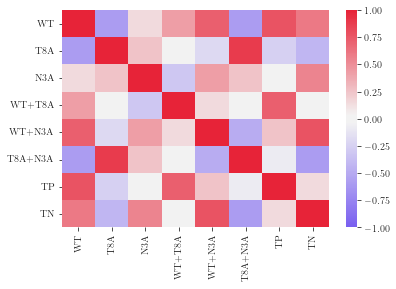

In [44]:
sns.heatmap(
    wt_lungs_circ_df[(wt_lungs_circ_df.Challenge == "T8A challenge")].corr(
        method="spearman"
    ),
    vmin=-1,
    vmax=1,
    annot=False,
    cmap=sns.diverging_palette(270, 10, s=90, sep=10, as_cmap=True),
)
# plt.savefig("TEST.pdf")

## T8A Priming
### Spleen
#### Circulating

In [45]:
t8a_spleen_circ_df = t8a_spleen_circ_exp.to_df(filename="T8A-S-Cir", frequency=False)
t8a_spleen_circ_df_feq = t8a_spleen_circ_exp.to_df(filename="T8A-S-Cir-F")

In [46]:
t8a_spleen_circ_exp.combined_correlation_plot("Fig-Correlations/S-T8A-S-Cir")
for challenge in ["WT", "T8A", "N3A"]:
    t8a_spleen_circ_exp.correlation_plot(
        challenge, filename=f"Fig-Correlations/S-T8A-{challenge}-S-Cric"
    )

#### Resident

In [47]:
t8a_spleen_res_df = t8a_spleen_res_exp.to_df(filename="T8A-S-Res", frequency=False)
t8a_spleen_res_df_feq = t8a_spleen_res_exp.to_df(filename="T8A-S-Res-F")

In [48]:
t8a_spleen_res_exp.combined_correlation_plot("Fig-Correlations/S-T8A-S-Res")
for challenge in ["WT", "T8A", "N3A"]:
    t8a_spleen_res_exp.correlation_plot(
        challenge, filename=f"Fig-Correlations/S-T8A-{challenge}-S-Res"
    )

### Lungs
#### Circulating

In [49]:
t8a_lungs_circ_df = t8a_lungs_circ_exp.to_df(filename="T8A-L-Cir", frequency=False)
t8a_lungs_circ_df_feq = t8a_lungs_circ_exp.to_df(filename="T8A-L-Cir-F")

In [50]:
t8a_lungs_circ_exp.combined_correlation_plot("Fig-Correlations/S-T8A-L-Cir")
for challenge in ["WT", "T8A", "N3A"]:
    t8a_lungs_circ_exp.correlation_plot(
        challenge, filename=f"Fig-Correlations/S-T8A-{challenge}-L-Cric"
    )

#### Resident

In [51]:
t8a_lungs_res_df = t8a_lungs_res_exp.to_df(filename="T8A-L-Res", frequency=False)
t8a_lungs_res_df_feq = t8a_lungs_res_exp.to_df(filename="T8A-L-Res-F")

In [52]:
t8a_lungs_res_exp.combined_correlation_plot("Fig-Correlations/S-T8A-L-Res")
for challenge in ["WT", "T8A", "N3A"]:
    t8a_lungs_res_exp.correlation_plot(
        challenge, filename=f"Fig-Correlations/S-T8A-{challenge}-L-Res"
    )

## N3A Priming
### Spleen
#### Circulating

In [53]:
n3a_spleen_circ_df = n3a_spleen_circ_exp.to_df(filename="N3A-S-Cir", frequency=False)
n3a_spleen_circ_df_feq = n3a_spleen_circ_exp.to_df(filename="N3A-S-Cir-F")

In [54]:
n3a_spleen_circ_exp.combined_correlation_plot("Fig-Correlations/S-N3A-S-Cir")
for challenge in ["WT", "T8A", "N3A"]:
    n3a_spleen_circ_exp.correlation_plot(
        challenge, filename=f"Fig-Correlations/S-N3A-{challenge}-S-Cric"
    )

#### Resident

In [55]:
n3a_spleen_res_df = n3a_spleen_res_exp.to_df(filename="N3A-S-Res", frequency=False)
n3a_spleen_res_df_feq = n3a_spleen_res_exp.to_df(filename="N3A-S-Res-F")

In [56]:
n3a_spleen_res_exp.combined_correlation_plot("Fig-Correlations/S-N3A-S-Res")
for challenge in ["WT", "T8A", "N3A"]:
    n3a_spleen_res_exp.correlation_plot(
        challenge, filename=f"Fig-Correlations/S-N3A-{challenge}-S-Res"
    )

### Lungs
#### Circulating

In [57]:
n3a_lungs_circ_df = n3a_lungs_circ_exp.to_df(filename="N3A-L-Cir", frequency=False)
n3a_lungs_circ_df_feq = n3a_lungs_circ_exp.to_df(filename="N3A-L-Cir-F")

In [58]:
n3a_lungs_circ_exp.combined_correlation_plot("Fig-Correlations/S-N3A-L-Cir")
for challenge in ["WT", "T8A", "N3A"]:
    n3a_lungs_circ_exp.correlation_plot(
        challenge, filename=f"Fig-Correlations/S-N3A-{challenge}-L-Cric"
    )

#### Resident

In [59]:
n3a_lungs_res_df = n3a_lungs_res_exp.to_df(filename="N3A-L-Res", frequency=False)
n3a_lungs_res_df_feq = n3a_lungs_res_exp.to_df(filename="N3A-L-Res-F")

In [60]:
n3a_lungs_res_exp.combined_correlation_plot("Fig-Correlations/S-N3A-L-Res")
for challenge in ["WT", "T8A", "N3A"]:
    n3a_lungs_res_exp.correlation_plot(
        challenge, filename=f"Fig-Correlations/S-N3A-{challenge}-L-Res"
    )

# Naive

## Absolute numbers

In [ ]:
fa.header_clipping("Naive", check=True)

In [ ]:
fa.header_clipping("Naive")

naive_headers = [
    "Tissue",
    "Stain for Column Selection",
    "CD8_WTSP_Num",
    "CD8_T8ASP_Num",
    "CD8_WTT8ADP_Num",
    "CD8_N3ASP_Num",
    "CD8_WTN3ADP_Num",
    "CD8_N3AT8ADP_Num",
    "CD8_TriplePos_Num",
    "CD8_Num",
]

naive_column_names = fa.time_name_list("Naive", naive_headers)

naive_data, naive_data_neg = fa.data_extraction(
    "Naive", "Spleen + Lymphnodes", naive_headers, naive_column_names
)

naive_means, naive_actual_mice = fa.population_means(naive_data)

naive_means_neg, naive_actual_mice_neg = fa.population_means(naive_data_neg)

In [ ]:
if absolute_numbers:
    fa.venn_plots(
        3,
        naive_data,
        naiveColumns,
        tetramerNames,
        title="Naive mice",
        file_name="V-Naive-AN",
        # ignore=[0, 4],
    )

In [ ]:
fa.header_clipping("Naive", filename="WT", check=True)
fa.header_clipping("Naive", filename="T8A", check=True)
fa.header_clipping("Naive", filename="N3A", check=True)

In [ ]:
fa.header_clipping("Naive", filename="WT")
fa.header_clipping("Naive", filename="T8A")
fa.header_clipping("Naive", filename="N3A")

naive_wt_headers = [
    "Tissue",
    "Stain for Column Selection",
    "CD8_WT_N3AT8Aneg_Num",
    "CD8_WT_T8ASP_Num",
    "CD8_WT_N3ASP_Num",
    "CD8_WT_N3AT8ADP_Num",
    "Column Selected WT Positive_Num",
]

naive_t8a_headers = [
    "Tissue",
    "Stain for Column Selection",
    "CD8_T8A_N3AWTneg_Num",
    "CD8_T8A_WTSP_Num",
    "CD8_T8A_N3ASP_Num",
    "CD8_T8A_N3AWTDP_Num",
    "Column Selected T8A Positive_Num",
]

naive_n3a_headers = [
    "Tissue",
    "Stain for Column Selection",
    "CD8_N3A_WTT8Aneg_Num",
    "CD8_N3A_WTSP_Num",
    "CD8_N3A_T8ASP_Num",
    "CD8_N3A_T8AWTDP_Num",
    "Column Selected N3A Positive_Num",
]

naive_wt_column_names = fa.time_name_list("Naive", naive_wt_headers, filename="WT")
naive_t8a_column_names = fa.time_name_list("Naive", naive_t8a_headers, filename="T8A")
naive_n3a_column_names = fa.time_name_list("Naive", naive_n3a_headers, filename="N3A")

naive_wt_data, _ = fa.data_extraction(
    "Naive",
    "Spleen + Lymphnodes",
    naive_wt_headers,
    naive_wt_column_names,
    data_type="naive",
    column="WT",
    filename="WT",
)

naive_t8a_data, _ = fa.data_extraction(
    "Naive",
    "Spleen + Lymphnodes",
    naive_t8a_headers,
    naive_t8a_column_names,
    data_type="naive",
    column="T8A",
    filename="T8A",
)

naive_n3a_data, _ = fa.data_extraction(
    "Naive",
    "Spleen + Lymphnodes",
    naive_n3a_headers,
    naive_n3a_column_names,
    data_type="naive",
    column="N3A",
    filename="N3A",
)

In [ ]:
combined_naive_data = fa.combine_naive_data(
    [naive_wt_data, naive_t8a_data, naive_n3a_data]
)

In [ ]:
statsDF = fa.stats_dataframe_naive(combined_naive_data, naive_stats_column_names)

In [ ]:
if absolute_numbers:
    # sns.pairplot(statsDF, diag_kind="kde", height=1.5)

    grid = sns.PairGrid(data=statsDF, height=1.5, diag_sharey=False)
    grid.map_diag(sns.kdeplot)
    grid.map_lower(sns.scatterplot)
    grid.map_upper(fa.pairs_stats, comparisons=comb(12, 2))
    grid.figure.savefig("S-Naive-AN.pdf")
    # grid.tight_layout()

    plt.close("all")

In [ ]:
if absolute_numbers:
    fa.venn_plots(
        3,
        combined_naive_data,
        naiveColumns,
        tetramerNames,
        title="Naive mice",
        file_name="V-Naive-C-AN",
    )

## Frequencies

In [ ]:
fa.header_clipping("Naive", filename="WT")
fa.header_clipping("Naive", filename="T8A")
fa.header_clipping("Naive", filename="N3A")

naive_wt_headers = [
    "Tissue",
    "Stain for Column Selection",
    "CD8_WT_N3AT8Aneg_Num",
    "CD8_WT_T8ASP_Num",
    "CD8_WT_N3ASP_Num",
    "CD8_WT_N3AT8ADP_Num",
    "Column Selected WT Positive_Num",
]

naive_t8a_headers = [
    "Tissue",
    "Stain for Column Selection",
    "CD8_T8A_N3AWTneg_Num",
    "CD8_T8A_WTSP_Num",
    "CD8_T8A_N3ASP_Num",
    "CD8_T8A_N3AWTDP_Num",
    "Column Selected T8A Positive_Num",
]

naive_n3a_headers = [
    "Tissue",
    "Stain for Column Selection",
    "CD8_N3A_WTT8Aneg_Num",
    "CD8_N3A_WTSP_Num",
    "CD8_N3A_T8ASP_Num",
    "CD8_N3A_T8AWTDP_Num",
    "Column Selected N3A Positive_Num",
]

naive_wt_column_names = fa.time_name_list("Naive", naive_wt_headers, filename="WT")
naive_t8a_column_names = fa.time_name_list("Naive", naive_t8a_headers, filename="T8A")
naive_n3a_column_names = fa.time_name_list("Naive", naive_n3a_headers, filename="N3A")

naive_wt_data_freq, naive_wt_data_neg_norm = fa.data_extraction(
    "Naive",
    "Spleen + Lymphnodes",
    naive_wt_headers,
    naive_wt_column_names,
    data_type="naive",
    column="WT",
    filename="WT",
    normalise=True,
)

naive_t8a_data_freq, naive_t8a_data_neg_norm = fa.data_extraction(
    "Naive",
    "Spleen + Lymphnodes",
    naive_t8a_headers,
    naive_t8a_column_names,
    data_type="naive",
    column="T8A",
    filename="T8A",
    normalise=True,
)

naive_n3a_data_freq, naive_n3a_data_neg_norm = fa.data_extraction(
    "Naive",
    "Spleen + Lymphnodes",
    naive_n3a_headers,
    naive_n3a_column_names,
    data_type="naive",
    column="N3A",
    filename="N3A",
    normalise=True,
)

combined_naive_data_freq = fa.combine_naive_data(
    [naive_wt_data_freq, naive_t8a_data_freq, naive_n3a_data_freq]
)

stats_freqDF = fa.stats_dataframe_naive(
    combined_naive_data_freq, naive_stats_column_names
)

In [ ]:
grid = sns.PairGrid(data=stats_freqDF, height=1.5, diag_sharey=False)
grid.map_diag(sns.kdeplot)
grid.map_lower(sns.scatterplot)
grid.map_upper(fa.pairs_stats, comparisons=comb(12, 2))
grid.figure.savefig("S-Naive.pdf")

plt.close("all")

In [ ]:
fa.venn_plots(
    3,
    combined_naive_data_freq,
    naiveColumns,
    tetramerNames,
    title="Naive data (frequencies)",
    file_name="V-Naive",
    decimals=3,
)

# Plotly tests

## Plots

In [ ]:
data = [
    wt_p_data,
    t8a_p_data,
    n3a_p_data,
    wt_p_data_neg,
    t8a_p_data_neg,
    n3a_p_data_neg,
]
priming = ["WT", "T8A", "N3A"]
time = [10, 70, 90, 90, 90]
organ = ["Spleen", "Spleen", "Spleen"]
cd45 = ["-", "-", "-"]
columns = ["Organ", "CD45", "Priming", "Time (dpi)", "Cells", "Tetramer", "Timepoint"]
infection_dict = {0: "Primary", 1: "Memory", 2: "WT", 3: "T8A", 4: "N3A"}
patch_dict = {
    0: "WT",
    1: "T8A",
    3: "N3A",
    2: "WT+T8A",
    4: "WT+N3A",
    5: "T8A+N3A",
    6: "Triple positive",
}

dataDF = fa.plot_dataframe(
    data, priming, time, organ, cd45, columns, patch_dict, infection_dict
)

In [ ]:
fig = px.line(
    dataDF[
        (dataDF.Timepoint == "Primary")
        | (dataDF.Timepoint == "Memory")
        | (dataDF.Timepoint == "WT")
    ],
    x="Time (dpi)",
    y="Cells",
    color="Tetramer",
    title="Contration and expansion slopes",
    markers=True,
    log_y=False  # ,
    # symbol='Priming'
)

# fig.show()

fig.write_html("single-slope-plot.html")

In [ ]:
dataDF[
    (dataDF.Timepoint == "WT")
    | (dataDF.Timepoint == "T8A")
    | (dataDF.Timepoint == "N3A")
]

## Multi-col test

In [ ]:
times = [10, 70, 90]
left_col = [0, 1, 2, 6, 7, 8, 12, 13, 14]
right_col = [3, 4, 5, 9, 10, 11, 15, 16, 17]
colours = ["#29e0c3", "#f28b2e", "#34a0e0"]
tetramers = ["WT", "T8A", "N3A"]

fig = go.Figure().set_subplots(
    rows=3,
    cols=2,
    subplot_titles=(
        "WT primary",
        "WT primary",
        "T8A primary",
        "T8A primary",
        "N3A primary",
        "N3A primary",
    ),
    shared_xaxes=True,
    shared_yaxes=True,
    vertical_spacing=0.05,
)

fig.update_layout(
    legend_title_text="Challenge infection",
    legend=dict(
        yanchor="bottom",
        xanchor="center",
        y=1.02,
        x=0.5,
        orientation="h",
        font={"size": 18},
    ),
    height=1200,
    width=750,
)

fig.update_xaxes(title_text="Time (dpi)", row=3, col=1)
fig.update_xaxes(title_text="Time (dpi)", row=3, col=2)
fig.update_xaxes(tickvals=[10, 70, 90], title_font={"size": 14})
fig.update_yaxes(title_text="Cells", title_font={"size": 14}, col=1)
# fig.update_yaxes(type='log')
# , rangemode='nonnegative')


# WT primary

# Left column
for colour, challenge in enumerate(tetramers):
    fig.add_trace(
        go.Scatter(
            x=times,
            y=fa.separate_data(dataDF, "WT", challenge, "WT").Cells,
            mode="lines+markers",
            name=challenge,
            line=dict(color=colours[colour]),
        ),
        1,
        1,
    )


# Right column
for colour, challenge in enumerate(tetramers):
    fig.add_trace(
        go.Scatter(
            x=times,
            y=fa.separate_data(dataDF, "WT", challenge, "WT").Cells,
            mode="lines+markers",
            name=challenge,
            showlegend=False,
            line=dict(color=colours[colour]),
        ),
        1,
        2,
    )

# SEPARATE INTO ONE LINE FOR FIRST CONTRACTION AND 3 LINES FOR EXPASIONS


# T8A primary

# Left column
for colour, challenge in enumerate(tetramers):
    fig.add_trace(
        go.Scatter(
            x=times,
            y=fa.separate_data(dataDF, "T8A", challenge, "WT").Cells,
            mode="lines+markers",
            name=challenge,
            showlegend=False,
            line=dict(color=colours[colour]),
        ),
        2,
        1,
    )

# Right column
for colour, challenge in enumerate(tetramers):
    fig.add_trace(
        go.Scatter(
            x=times,
            y=fa.separate_data(dataDF, "T8A", challenge, "WT").Cells,
            mode="lines+markers",
            name=challenge,
            showlegend=False,
            line=dict(color=colours[colour]),
        ),
        2,
        2,
    )

# SEPARATE INTO ONE LINE FOR FIRST CONTRACTION AND 3 LINES FOR EXPASIONS


# N3A primary

# Left column
for colour, challenge in enumerate(tetramers):
    fig.add_trace(
        go.Scatter(
            x=times,
            y=fa.separate_data(dataDF, "N3A", challenge, "WT").Cells,
            mode="lines+markers",
            name=challenge,
            showlegend=False,
            line=dict(color=colours[colour]),
        ),
        3,
        1,
    )

# Right column
for colour, challenge in enumerate(tetramers):
    fig.add_trace(
        go.Scatter(
            x=times,
            y=fa.separate_data(dataDF, "N3A", challenge, "WT").Cells,
            mode="lines+markers",
            name=challenge,
            showlegend=False,
            line=dict(color=colours[colour]),
        ),
        3,
        2,
    )

# SEPARATE INTO ONE LINE FOR FIRST CONTRACTION AND 3 LINES FOR EXPASIONS

fig.update_layout(
    updatemenus=[
        dict(
            # type="buttons",  # Remove for dropdown
            direction="down",  # down if dropdown, right if buttons
            x=0.25,
            y=1.06,
            showactive=True,
            xanchor="center",
            yanchor="bottom",
            buttons=list(
                [
                    dict(
                        label="WT",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "WT")}, left_col],
                    ),
                    dict(
                        label="T8A",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "T8A")}, left_col],
                    ),
                    dict(
                        label="N3A",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "N3A")}, left_col],
                    ),
                    dict(
                        label="WT+T8A",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "WT+T8A")}, left_col],
                    ),
                    dict(
                        label="WT+N3A",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "WT+N3A")}, left_col],
                    ),
                    dict(
                        label="T8A+N3A",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "T8A+N3A")}, left_col],
                    ),
                    dict(
                        label="Triple positive",
                        method="restyle",
                        args=[
                            {"y": fa.data_update(dataDF, "Triple positive")},
                            left_col,
                        ],
                    ),
                    dict(
                        label="Triple negative",
                        method="restyle",
                        args=[
                            {"y": fa.data_update(dataDF, "Triple negative")},
                            left_col,
                        ],
                    ),
                    dict(
                        label="Total",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "Total")}, left_col],
                    ),
                ]
            ),
        ),
        dict(
            direction="down",
            x=0.75,
            y=1.06,
            showactive=True,
            xanchor="center",
            yanchor="bottom",
            buttons=list(
                [
                    dict(
                        label="WT",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "WT")}, right_col],
                    ),
                    dict(
                        label="T8A",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "T8A")}, right_col],
                    ),
                    dict(
                        label="N3A",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "N3A")}, right_col],
                    ),
                    dict(
                        label="WT+T8A",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "WT+T8A")}, right_col],
                    ),
                    dict(
                        label="WT+N3A",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "WT+N3A")}, right_col],
                    ),
                    dict(
                        label="T8A+N3A",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "T8A+N3A")}, right_col],
                    ),
                    dict(
                        label="Triple positive",
                        method="restyle",
                        args=[
                            {"y": fa.data_update(dataDF, "Triple positive")},
                            right_col,
                        ],
                    ),
                    dict(
                        label="Triple negative",
                        method="restyle",
                        args=[
                            {"y": fa.data_update(dataDF, "Triple negative")},
                            right_col,
                        ],
                    ),
                    dict(
                        label="Total",
                        method="restyle",
                        args=[{"y": fa.data_update(dataDF, "Total")}, right_col],
                    ),
                ]
            ),
        ),
    ]
)

# fig.show()

fig.write_html("slope-plots.html")

In [ ]:
def data_test(positive_data, total_data):
    print(
        f"{'Mouse' : ^9}{'Time' : ^8}{'Positive' : ^12}{'Total' : ^12}{'Fraction' : ^12}{'Correct' : ^11}"
    )
    print("=" * 64)
    for mouse in range(len(positive_data)):
        for current_time in range(len(positive_data[mouse])):
            print(
                f"{mouse + 1 : ^9}{current_time + 1 : ^8}{sum(positive_data[mouse][current_time]) : ^12}{total_data[mouse][current_time][0] : ^12}{round(sum(positive_data[mouse][current_time]) / total_data[mouse][current_time][0], 5) : ^12}{sum(positive_data[mouse][current_time]) <= total_data[mouse][current_time][0] : ^11}"
            )

In [ ]:
data_test(n3a_p_data, n3a_p_data_neg)

# Tests

In [ ]:
test = fa.Mouse(1, 2, 3, 4, 5, 6, 7.257567, 0.124143141)

In [ ]:
test.venn()

In [ ]:
round(test)

In [ ]:
test1 = fa.Mouse()
test1.venn()

In [ ]:
round(test1)